# Relatório Air Quality and Weather in Madrid

In [1]:
from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np

## Variáveis globais

- wt-madrid: caminho para o arquivo com os dados meteorológicos
- aq-madrid: caminho para o arquivo com os dados de qualidade do ar

In [2]:
ARGS = {
    "wt-madrid": "dataset/extract/wt_madrid.h5",
    "aq-madrid": "dataset/extract/aq_madrid.h5",
}

## Funções

__describe_function__

Função que recebe um dataframe como entrada e gera um dataframe de saída com a descrição dos dados.

In [3]:
def describe_data(df: pd.DataFrame) -> pd.DataFrame:
    """This function describe the datas of a dataframe. Returning the max,
    min, mean, median, quantile, variance, standard deviation,
    mean absolute deviation, amplitude, root mean squared, kurtosis, skewness
    and count for all headers in dataframe

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe of input

    Returns
    -------
    pd.DataFrame
        Dataframe with the descriptions
    """

    FIRST_QUARTILE = 0.25
    THIRD_QUARTILE = 0.75
    IQR_CONSTANT = 1.5

    def _apply(header: str, column: []):
        _max = column.max()
        _min = column.min()

        # Scatter
        _q1 = column.quantile(FIRST_QUARTILE)
        _q3 = column.quantile(THIRD_QUARTILE)
        _iqr = _q3 - _q1
        _lower = max(_min, _q1 - (IQR_CONSTANT * _iqr))
        _upper = min(_max, _q3 + (IQR_CONSTANT * _iqr))

        return {
            "header": header,
            "max": _max,
            "min": _min,
            "mean": column.mean(),
            "median": column.median(),
            "lower limit": _lower,
            "1-quartile": _q1,
            "3-quartile": _q3,
            "upper limit": _upper,
            "var": column.var(),
            "std": column.std(),
            "mad": column.mad(),
            "amp": _max - _min,
            "rms": (column.pow(2)).mean() ** 0.5,
            "kurtosis": column.kurtosis(),
            "skew": column.skew(),
            "count": column.count(),
            "nans": column.isna().sum(),
        }

    return pd.DataFrame(
        [_apply(_, df.loc[:, _]) for _ in df.columns]
    ).set_index("header")

__corrplot__

Função que recebe um dataframe como entrada e gera o gráfico de correlação entre as variáveis.

In [4]:
def corrplot(df):
    """This function show correlation chart

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe of input
    """
    
    corr = df.corr('pearson', 1)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):
        _, ax1 = plt.subplots(1, 1, figsize=(18, 8))
        ax = sns.heatmap(
            corr,
            mask=mask,
            vmin=-1,
            vmax=1,
            annot=True,
            cmap='coolwarm',
            square=True,
            linewidths=.5,
            ax=ax1,
        )

## Datasets

### Weather Madrid 1997 - 2015

Dados do clima do aeroporto de Barajas, Madri, entre 1997 e 2015. Obtido em https://www.wunderground.com/ The Weather Company, LLC

Campos:
- Max TemperatureC
- Mean TemperatureC
- Min TemperatureC
- Dew PointC
- MeanDew PointC
- Min DewpointC
- Max Humidity
- Mean Humidity
- Min Humidity
- Max Sea Level PressurehPa
- Mean Sea Level PressurehPa
- Min Sea Level PressurehPa
- Max VisibilityKm
- Mean VisibilityKm
- Min VisibilitykM
- Max Wind SpeedKm/h
- Mean Wind SpeedKm/h
- Max Gust SpeedKm/h
- Precipitationmm
- CloudCover
- Events
- WindDirDegrees

Lê e exibe as chaves presentes em wt-madrid:

In [5]:
df_wt = pd.HDFStore(ARGS.get("wt-madrid"))
df_wt.keys()

['/master']

#### Pré-processamento

Filtra os dados no período de 2001 a 2015:

In [6]:
LOWER_LIMIT_DATE = "2001"

weather = df_wt.get("master")
weather = weather.set_index("CET")
weather = weather.sort_values("CET")
weather.index = pd.to_datetime(weather.index)
weather = weather[weather.index >= LOWER_LIMIT_DATE]

#### Análise exploratória

Os dados tratam-se de uma série temporal com a granularidade diária.

In [7]:
weather

,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,...,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
CET,,,,,,,,,,,,,,,,,,,,,
2001-01-01,10.0,7.0,4.0,9.0,6.0,3.0,100.0,89.0,81.0,1017,...,10.0,9.0,3.0,26,11,NaN,0.0,6.0,Rain,204
2001-01-10,10.0,7.0,3.0,9.0,6.0,3.0,100.0,98.0,87.0,1017,...,10.0,5.0,3.0,21,5,NaN,0.0,6.0,Rain,337
2001-01-11,11.0,8.0,5.0,9.0,7.0,5.0,100.0,90.0,76.0,1013,...,10.0,9.0,6.0,27,16,NaN,0.0,6.0,Rain,170
2001-01-12,9.0,7.0,6.0,7.0,6.0,4.0,100.0,93.0,81.0,1013,...,10.0,9.0,5.0,16,6,NaN,0.0,5.0,Rain,14
2001-01-13,12.0,6.0,1.0,5.0,3.0,0.0,100.0,78.0,58.0,1020,...,10.0,10.0,10.0,16,8,NaN,0.0,4.0,NaN,348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-05,27.0,20.0,12.0,10.0,7.0,3.0,67.0,42.0,14.0,1021,...,31.0,18.0,10.0,16,11,37.0,0.0,1.0,NaN,7
2015-09-06,28.0,21.0,15.0,11.0,8.0,5.0,63.0,40.0,16.0,1023,...,31.0,19.0,10.0,13,6,NaN,0.0,1.0,NaN,358
2015-09-07,27.0,21.0,16.0,13.0,9.0,3.0,68.0,46.0,15.0,1022,...,31.0,19.0,10.0,23,10,35.0,0.0,1.0,NaN,108


É observado presença de atributos:

- discretos:
 - Max Sea Level PressurehPa
 - Mean Sea Level PressurehPa
 - Min Sea Level PressurehPa
 - WindDirDegrees
- contínuos:
 - Max TemperatureC
 - Mean TemperatureC
 - Min TemperatureC
 - Dew PointC
 - MeanDew PointC
 - Min DewpointC
 - Max Humidity
 - Mean Humidity
 - Min Humidity
 - Max VisibilityKm
 - Mean VisibilityKm
 - Min VisibilitykM
 - Max Gust SpeedKm/h
 - Precipitationmm
 - CloudCover
- categóricos:
 - Events

In [8]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5448 entries, 2001-01-01 to 2015-09-09
Data columns (total 22 columns):
Max TemperatureC               5446 non-null float64
Mean TemperatureC              5446 non-null float64
Min TemperatureC               5446 non-null float64
Dew PointC                     5446 non-null float64
MeanDew PointC                 5446 non-null float64
Min DewpointC                  5446 non-null float64
Max Humidity                   5446 non-null float64
 Mean Humidity                 5446 non-null float64
 Min Humidity                  5446 non-null float64
 Max Sea Level PressurehPa     5448 non-null int64
 Mean Sea Level PressurehPa    5448 non-null int64
 Min Sea Level PressurehPa     5448 non-null int64
 Max VisibilityKm              4686 non-null float64
 Mean VisibilityKm             4686 non-null float64
 Min VisibilitykM              4686 non-null float64
 Max Wind SpeedKm/h            5448 non-null int64
 Mean Wind SpeedKm/h           5448

Análise descritiva sobre os dados:

Através da função describe, é possível resumir os dados de forma que possibilite identificar o comportamento dos dados, como por exemplo:

- [1] Se os dados possuem uma distribuição normalizada (skew e kurtosis = 0). Nesse caso, grande parte dos dados possuem quase uma distribuição normal, com exceção de: Precipitationmm; Min VisibilitykM; Max Wind SpeedKm/h; e Mean VisibilityKm
- [2] A presença de valores ausentes em: Max Gust SpeedKm/h; CloudCover; e VisibilityKm

Em [1], também contribui para identificação da dispersão dos dados
Em [2], para alguns tipos de variáveis onde a quantidade de valores ausentes são pequenos, é possível corrigir com a técnica de interpolação, mas variáveis onde possuem um "gap" maior, talvez a interpolação prejudique a confiabilidade dos dados.

In [75]:
describe_data(weather.drop(" Events", axis=1))

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
Max TemperatureC,41.0,0.0,21.040947,20.0,0.0,13.0,29.00,41.0,80.283171,8.960088,7.772849,41.0,22.868972,-1.130591,0.147035,5446,2
Mean TemperatureC,31.0,-3.0,14.658649,14.0,-3.0,8.0,21.00,31.0,58.616057,7.656112,6.645929,34.0,16.537269,-1.076837,0.130431,5446,2
Min TemperatureC,26.0,-10.0,8.610356,9.0,-10.0,3.0,14.00,26.0,47.458067,6.888982,5.817300,36.0,11.026676,-0.911719,-0.047801,5446,2
Dew PointC,20.0,-12.0,7.932978,8.0,-4.0,5.0,11.00,20.0,22.447114,4.737839,3.778273,32.0,9.239867,0.144054,-0.471266,5446,2
MeanDew PointC,16.0,-15.0,4.764781,5.0,-7.0,2.0,8.00,16.0,21.740989,4.662723,3.740668,31.0,6.666344,0.302677,-0.486140,5446,2
Min DewpointC,14.0,-22.0,1.185090,1.0,-12.5,-2.0,5.00,14.0,24.289702,4.928458,3.924266,36.0,5.068499,0.520687,-0.422546,5446,2
Max Humidity,100.0,26.0,80.616783,87.0,26.5,67.0,94.00,100.0,321.339435,17.925943,15.323279,74.0,82.585387,-0.663000,-0.679028,5446,2
Mean Humidity,99.0,15.0,57.308667,58.0,15.0,40.0,74.00,99.0,401.066691,20.026650,17.248992,84.0,60.706477,-1.115221,-0.009115,5446,2
Min Humidity,93.0,4.0,33.729526,30.0,4.0,17.0,47.00,92.0,381.597905,19.534531,16.209607,89.0,38.977029,-0.364646,0.653752,5446,2


Gráfico de evolução

Aplicando o filtro sobre os atributos dos clima, é possível perceber que grande parte dessas variáveis possuem uma sazonalidade anual, onde os maiores "picos" são apresentados nos meses entre junho e agosto.

In [62]:
@interact(
    column=widgets.Select(options=weather.columns, disabled=False)
)
def localplot(column):
    try:
        aux = weather.copy()
        aux = aux.groupby(aux.index.date).mean()
        fig = px.line(
            x=aux.index,
            y=aux[column].values,
            title=f'Gráfico de evolução de {column}',
            labels={"x": "data", "y": column}
        )
        fig.show()
    except Exception as e:
        print(e)

interactive(children=(Select(description='column', options=('Max TemperatureC', 'Mean TemperatureC', 'Min Temp…

Gráfico de correlação:

As correlações que se destacam são:

- Positiva (> 0.5):
 - MeanDew PointC <-> Mean TemperatureC
 - CloudCover <-> Mean Humidity
- Negativa (< -0.5):
 - Mean Humidity <-> Mean TemperatureC

In [10]:
@interact(
    columns=widgets.SelectMultiple(options=weather.columns, disabled=False)
)
def localplot(columns):
    try:
        corrplot(weather[list(columns)])
    except Exception as e:
        print(e)

interactive(children=(SelectMultiple(description='columns', options=('Max TemperatureC', 'Mean TemperatureC', …

Visualização completa das correlações

In [64]:
@interact(
    columns=widgets.SelectMultiple(options=weather.columns, disabled=False)
)
def localplot(columns):
    fig = px.scatter_matrix(
        weather,
        dimensions=list(columns)
    )
    fig.show()

interactive(children=(SelectMultiple(description='columns', options=('Max TemperatureC', 'Mean TemperatureC', …

---

### Air Quality in Madrid (2001-2018)

Inclui dados históricos diário e horário dos níveis de qualidade do ar registrados de 2001 a 2018 e a lista das estações usadas para análise de poluição e outras particulas.

Fields:
- SO_2: sulphur dioxide level measured in μg/m³. High levels of sulphur dioxide can produce irritation in the skin and membranes, and worsen asthma or heart diseases in sensitive groups.
- CO: carbon monoxide level measured in mg/m³. Carbon monoxide poisoning involves headaches, dizziness and confusion in short exposures and can result in loss of consciousness, arrhythmias, seizures or even death in the long term.
- NO: nitric oxide level measured in μg/m³. This is a highly corrosive gas generated among others by motor vehicles and fuel burning processes.
- NO_2: nitrogen dioxide level measured in μg/m³. Long-term exposure is a cause of chronic lung diseases, and are harmful for the vegetation.
- PM25: particles smaller than 2.5 μm level measured in μg/m³. The size of these particles allow them to penetrate into the gas exchange regions of the lungs (alveolus) and even enter the arteries. Long-term exposure is proven to be related to low birth weight and high blood pressure in newborn babies.
- PM10: particles smaller than 10 μm. Even though the cannot penetrate the alveolus, they can still penetrate through the lungs and affect other organs. Long term exposure can result in lung cancer and cardiovascular complications
- NOx: nitrous oxides level measured in μg/m³. Affect the human respiratory system worsening asthma or other diseases, and are responsible of the yellowish-brown color of photochemical smog.
- O_3: ozone level measured in μg/m³. High levels can produce asthma, bronchytis or other chronic pulmonary diseases in sensitive groups or outdoor workers.
- TOL: toluene (methylbenzene) level measured in μg/m³. Long-term exposure to this substance (present in tobacco smkoke as well) can result in kidney complications or permanent brain damage.
- BEN: benzene level measured in μg/m³. Benzene is a eye and skin irritant, and long exposures may result in several types of cancer, leukaemia and anaemias. Benzene is considered a group 1 carcinogenic to humans by the IARC.
- EBE: ethylbenzene level measured in μg/m³. Long term exposure can cause hearing or kidney problems and the IARC has concluded that long-term exposure can produce cancer.
- MXY: m-xylene level measured in μg/m³. Xylenes can affect not only air but also water and soil, and a long exposure to high levels of xylenes can result in diseases affecting the liver, kidney and nervous system (especially memory and affected stimulus reaction).
- PXY: p-xylene level measured in μg/m³. See MXY for xylene exposure effects on health.
- OXY: o-xylene level measured in μg/m³. See MXY for xylene exposure effects on health.
- TCH: total hydrocarbons level measured in mg/m³. This group of substances can be responsible of different blood, immune system, liver, spleen, kidneys or lung diseases.
- CH4: methane level measured in mg/m³. This gas is an asphyxiant, which displaces the oxygen animals need to breath. Displaced oxygen can result in dizzinnes, weakness, nausea and loss of coordination.
- NMHC: non-methane hydrocarbons (volatile organic compounds) level measured in mg/m³. Long exposure to some of these substances can result in damage to the liver, kidney, and central nervous system. Some of them are suspected to cause cancer in humans.

Lê os dados de qualidade do ar e exibe as chaves (as chaves numéricas são os identificadores das estações):

In [12]:
df_aq = pd.HDFStore(ARGS.get("aq-madrid"))
df_aq.keys()

['/28079001',
 '/28079003',
 '/28079004',
 '/28079006',
 '/28079007',
 '/28079008',
 '/28079009',
 '/28079011',
 '/28079012',
 '/28079014',
 '/28079015',
 '/28079016',
 '/28079017',
 '/28079018',
 '/28079019',
 '/28079021',
 '/28079022',
 '/28079023',
 '/28079024',
 '/28079025',
 '/28079026',
 '/28079027',
 '/28079035',
 '/28079036',
 '/28079038',
 '/28079039',
 '/28079040',
 '/28079047',
 '/28079048',
 '/28079049',
 '/28079050',
 '/28079054',
 '/28079055',
 '/28079056',
 '/28079057',
 '/28079058',
 '/28079059',
 '/28079060',
 '/28079099',
 '/master']

#### Pré-processamento

Lista todas estações descritas no arquivo. Existem atributos:

- nominais:
 - name
 - address
- discretos:
 - id
 - elevation
- georreferenciado:
 - lon
 - lat

In [13]:
stations = df_aq.get("master")
stations

,id,name,address,lon,lat,elevation
0,28079004,Pza. de España,Plaza de España,-3.712247,40.423853,635
1,28079008,Escuelas Aguirre,Entre C/ Alcalá y C/ O’ Donell,-3.682319,40.421564,670
2,28079011,Avda. Ramón y Cajal,Avda. Ramón y Cajal esq. C/ Príncipe de Vergara,-3.677356,40.451475,708
3,28079016,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,-3.639233,40.440047,693
4,28079017,Villaverde,C/. Juan Peñalver,-3.713322,40.347139,604
5,28079018,Farolillo,Calle Farolillo - C/Ervigio,-3.731853,40.394781,630
6,28079024,Casa de Campo,Casa de Campo (Terminal del Teleférico),-3.747347,40.419356,642
7,28079027,Barajas Pueblo,"C/. Júpiter, 21 (Barajas)",-3.580031,40.476928,621
8,28079035,Pza. del Carmen,Plaza del Carmen esq. Tres Cruces.,-3.703172,40.419208,659
9,28079036,Moratalaz,Avd. Moratalaz esq. Camino de los Vinateros,-3.645306,40.407947,685


Filtra os dados no período de 2001 a 2015:

In [14]:
UPPER_LIMIT_DATE = "2016"
emissions = {}

try:
    for st in stations["id"]:
        aux = df_aq[str(st)]
        aux = aux.sort_values("date")
        emissions[st] = aux[aux.index < UPPER_LIMIT_DATE]
except Exception as e:
    print(f"[ERROR] {e}")
    df_aq.close()

#### Análise exploratória

Análise das informações presentes em uma estação específica:

- Possui granularidade horária
- Todos atributos (elementos químicos) são do tipo contínuo
- Existem valores ausentes

In [15]:
emissions[28079004]

,CO,NO,NO_2,NOx,O_3,PM10,SO_2
date,,,,,,,
2001-01-01 01:00:00,1.05,NaN,50.240002,132.699997,5.98,19.650000,20.610001
2001-01-01 02:00:00,1.77,NaN,47.970001,155.699997,6.13,38.730000,22.860001
2001-01-01 03:00:00,2.43,NaN,43.849998,222.600006,6.11,38.490002,24.910000
2001-01-01 04:00:00,2.06,NaN,44.500000,227.300003,6.29,45.369999,22.400000
2001-01-01 05:00:00,1.66,NaN,47.740002,200.699997,6.51,34.590000,21.600000
...,...,...,...,...,...,...,...
2015-12-31 19:00:00,0.40,17.0,55.000000,NaN,NaN,NaN,8.000000
2015-12-31 20:00:00,0.40,23.0,59.000000,NaN,NaN,NaN,8.000000
2015-12-31 21:00:00,0.40,27.0,68.000000,NaN,NaN,NaN,8.000000


Estatística descritiva sobre os dados de cada estação:

In [16]:
for em in emissions:
    display(
        f"Station: {em} {emissions[em].shape}",
        describe_data(emissions[em])
    )

'Station: 28079004 (131351, 7)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
CO,8.320000,0.0,0.531498,0.390000,0.0,0.280000,0.600000,1.080000,0.230119,0.479707,0.298690,8.320000,0.715966,24.958686,3.865567,130858,493
NO,740.000000,0.0,41.675728,14.000000,0.0,6.000000,43.000000,98.500000,4760.305239,68.994965,44.334264,740.000000,80.604358,12.244907,3.132875,43664,87687
NO_2,314.799988,0.0,55.185354,50.189999,0.0,32.209999,72.389999,132.660000,961.592846,31.009561,24.086397,314.799988,63.300939,2.204300,1.110048,130907,444
NOx,1337.000000,0.0,117.029779,82.320000,0.0,49.540001,142.500000,281.939999,11735.068082,108.328519,74.411756,1337.000000,159.470695,8.691664,2.494628,87242,44109
O_3,166.699997,0.0,35.225562,29.090000,0.0,10.550000,53.930000,119.000000,769.584351,27.741383,23.116949,166.699997,44.837649,0.137165,0.859097,78520,52831
PM10,290.399994,0.0,29.543884,21.760000,0.0,11.090000,39.220001,81.415003,680.824485,26.092614,19.136245,290.399994,39.416455,5.579555,1.961725,78274,53077
SO_2,130.699997,0.0,9.990337,8.000000,0.0,5.580000,11.910000,21.405000,62.142302,7.883039,5.132435,130.699997,12.725905,18.350799,3.235347,130926,425


/opt/anaconda/envs/aqw-madrid-data-analysis/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1112: RuntimeWarning:

Mean of empty slice



'Station: 28079008 (119183, 14)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
BEN,43.110001,0.0,0.910269,0.40,0.00,0.200000,0.920000,2.000000,2.841394,1.685643,0.848533,43.110001,1.915714,76.035680,6.825109,112035,7148
CH4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,119183
CO,10.400000,0.0,0.522695,0.40,0.00,0.300000,0.600000,1.050000,0.164653,0.405774,0.256829,10.400000,0.661710,27.822945,3.777241,118415,768
EBE,81.480003,0.0,1.332713,1.00,0.00,0.480000,1.600000,3.280000,2.351874,1.533582,0.926091,81.480003,2.031743,169.755943,7.016938,112022,7161
NMHC,6.860000,0.0,0.185995,0.16,0.00,0.110000,0.230000,0.410000,0.020351,0.142657,0.092556,6.860000,0.234404,107.700693,4.982416,96925,22258
NO,960.000000,1.0,33.317296,16.00,1.00,7.000000,36.000000,79.500000,2856.779962,53.448854,30.263421,959.000000,62.982188,33.354270,4.688473,43190,75993
NO_2,402.399994,0.0,62.439702,58.00,0.00,39.080002,79.220001,139.430000,1041.642877,32.274493,24.498648,402.399994,70.287627,4.072721,1.346373,118097,1086
NOx,1368.000000,0.0,125.915256,101.00,0.00,63.730000,155.000000,291.905001,9811.400427,99.052513,66.364465,1368.000000,160.205871,13.995542,2.884355,74903,44280
O_3,200.000000,0.0,34.404219,29.00,0.00,11.620000,50.810001,109.595004,707.078620,26.590950,21.544152,200.000000,43.482444,0.811555,0.987187,117576,1607


'Station: 28079011 (131423, 12)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
BEN,13.000000,0.10,1.646367,1.400000,0.10,0.700000,2.300000,4.700000,1.394000,1.180678,0.923346,12.900000,2.025956,3.934668,1.345107,52642,78781
CO,14.070000,0.00,0.542250,0.420000,0.00,0.220000,0.710000,1.445000,0.282964,0.531943,0.338359,14.070000,0.759602,42.044202,4.363435,78517,52906
EBE,15.400000,0.00,0.961913,0.600000,0.00,0.300000,1.020000,2.100000,1.274493,1.128934,0.705386,15.400000,1.483154,15.755399,3.307047,52611,78812
NMHC,3.420000,0.00,0.214653,0.180000,0.00,0.120000,0.280000,0.520000,0.023769,0.154172,0.108069,3.420000,0.264281,19.292754,2.698063,71580,59843
NO,1146.000000,1.00,27.627193,10.000000,1.00,3.000000,28.000000,65.500000,3148.772481,56.113924,28.781788,1145.000000,62.545681,54.922243,5.941627,43658,87765
NO_2,584.000000,0.00,50.917862,45.000000,0.00,26.330000,67.570000,129.429999,1185.503755,34.431145,25.417593,584.000000,61.466441,9.740459,1.964113,130848,575
NOx,2221.000000,0.00,98.477774,72.800003,0.00,40.102499,121.599998,243.846248,10087.454546,100.436321,62.328422,2221.000000,140.659912,33.061072,4.183791,87186,44237
O_3,166.100006,0.00,39.421790,36.775000,0.00,16.049999,57.790001,120.400003,702.073558,26.496671,21.986936,166.100006,47.498864,-0.059990,0.617224,78380,53043
PM10,342.399994,0.00,28.634971,21.780001,0.00,11.267500,38.110001,78.373751,617.525947,24.850069,18.025100,342.399994,37.914109,7.748594,2.128844,78428,52995


'Station: 28079016 (131351, 7)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
CO,10.52,0.0,0.392306,0.300000,0.0,0.20,0.450000,0.825000,0.137900,0.371349,0.215580,10.52,0.540188,54.138110,5.222252,130884,467
NO,844.00,1.0,19.461850,5.000000,1.0,2.00,15.000000,34.500000,1932.429319,43.959405,22.589888,843.00,48.074408,39.915993,5.295978,43670,87681
NO_2,356.00,0.0,43.255563,36.380001,0.0,21.00,58.709999,115.274998,895.937397,29.932213,22.967300,356.00,52.602037,3.642143,1.473991,130915,436
NOx,1444.00,0.0,75.195901,49.799999,0.0,28.17,90.629997,184.319993,6841.413996,82.712841,51.806998,1444.00,111.784432,23.007563,3.767528,87242,44109
O_3,203.00,0.0,44.051817,40.380001,0.0,17.00,64.379997,135.449993,942.551364,30.700999,25.324581,203.00,53.694569,0.005253,0.688027,130847,504
PM10,397.00,0.0,26.450904,19.930000,0.0,9.94,35.619999,74.139998,535.394822,23.138600,16.945480,397.00,35.143109,7.463089,2.068562,75920,55431
SO_2,166.50,0.0,10.461718,8.560000,0.0,6.75,12.150000,20.249999,39.663248,6.297877,4.085930,166.50,12.211073,26.648646,3.666138,78497,52854


'Station: 28079017 (94103, 7)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
CO,8.140000,0.0,0.726400,0.420000,0.0,0.27,0.800000,1.595000,0.699667,0.836461,0.537514,8.140000,1.107839,12.113048,3.084568,38894,55209
NO,768.000000,1.0,38.497581,5.000000,1.0,2.00,25.000000,59.500000,6869.084052,82.879938,50.538750,767.000000,91.383753,12.471501,3.320830,43617,50486
NO_2,336.000000,0.0,46.095075,37.880001,0.0,21.00,63.240002,126.600004,1095.141719,33.092926,25.737799,336.000000,56.744039,2.657701,1.391159,93537,566
NOx,1419.000000,0.0,106.271437,56.130001,0.0,30.52,123.300003,262.470007,17226.680483,131.250449,86.923891,1419.000000,168.878518,10.332197,2.853275,49921,44182
O_3,200.000000,0.0,39.287250,35.000000,0.0,10.00,60.000000,135.000000,969.888233,31.143029,25.858254,200.000000,50.133480,0.076825,0.756912,93025,1078
PM10,377.500000,0.0,39.256388,27.969999,0.0,14.31,52.770000,110.460001,1283.121847,35.820690,26.349489,377.500000,53.142758,4.737100,1.908789,38778,55325
SO_2,65.199997,0.0,7.154615,6.670000,0.0,4.54,8.240000,13.789999,17.620140,4.197635,2.807217,65.199997,8.295087,11.419719,2.447401,93545,558


'Station: 28079018 (129767, 12)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
BEN,13.850000,0.00,0.429670,0.200000,0.00,0.20,0.400000,0.700000,0.396004,0.629288,0.351865,13.850000,0.761979,42.507459,4.948350,52395,77372
CO,9.520000,0.00,0.500915,0.370000,0.00,0.23,0.600000,1.155000,0.234381,0.484129,0.300634,9.520000,0.696631,30.986036,4.098288,129200,567
EBE,20.000000,0.00,0.520308,0.300000,0.00,0.19,0.900000,1.965000,0.424502,0.651538,0.407221,20.000000,0.833795,69.694675,5.886298,52364,77403
NMHC,4.980000,0.00,0.236193,0.180000,0.00,0.09,0.310000,0.640000,0.044541,0.211047,0.148069,4.980000,0.316743,21.075813,2.872469,31463,98304
NO,539.000000,1.00,21.108060,4.000000,1.00,1.00,16.000000,38.500000,1826.228802,42.734398,26.164121,538.000000,47.662742,17.665283,3.641311,43485,86282
NO_2,407.200012,0.00,44.235372,36.495001,0.00,19.93,61.000000,122.605000,989.122720,31.450321,24.555340,407.200012,54.275991,2.963661,1.386585,129122,645
NOx,1278.000000,0.00,80.578271,49.820000,0.00,26.51,101.199997,213.234992,7468.688047,86.421572,58.926686,1278.000000,118.158616,12.435378,2.838715,85637,44130
O_3,210.000000,0.00,42.924566,39.240002,0.00,10.94,66.000000,148.590001,1127.060384,33.571720,28.124487,210.000000,54.493762,-0.257673,0.640630,129218,549
PM10,364.100006,0.00,26.710189,19.340000,0.00,10.75,34.200001,69.375002,589.165889,24.272740,17.035266,364.100006,36.091486,9.534969,2.443446,124475,5292


'Station: 28079024 (131087, 17)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
BEN,45.430000,0.0,0.686265,0.500000,0.000,0.30,0.800000,1.550000,0.547904,0.740205,0.434818,45.430000,1.009385,328.277771,8.746421,117921,13166
CH4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,131087
CO,4.430000,0.0,0.368033,0.300000,0.000,0.20,0.490000,0.925000,0.064202,0.253382,0.189611,4.430000,0.446823,8.538460,2.036865,129674,1413
EBE,57.799999,0.0,0.883717,0.740000,0.000,0.40,1.000000,1.900000,0.878293,0.937173,0.503839,57.799999,1.288115,481.357450,12.272462,113775,17312
MXY,99.580002,0.0,1.723249,1.000000,0.000,0.74,1.880000,3.590000,4.397144,2.096937,1.214727,99.580002,2.714161,163.102807,7.162124,72331,58756
NMHC,2.700000,0.0,0.177810,0.150000,0.000,0.09,0.240000,0.465000,0.013878,0.117807,0.090759,2.700000,0.213295,5.910608,1.549212,128597,2490
NO,369.000000,0.0,10.206343,1.000000,0.000,1.00,6.000000,13.500000,542.787857,23.297808,13.254047,369.000000,25.435109,21.495362,4.066804,43418,87669
NO_2,262.500000,0.0,29.989823,21.629999,0.000,9.65,43.540001,94.375003,694.784741,26.358770,20.764454,262.500000,39.927045,2.091418,1.381503,129615,1472
NOx,651.599976,0.0,49.031969,29.020000,0.000,14.01,63.520000,137.785001,2942.142942,54.241524,37.939422,651.599976,73.118006,9.646123,2.561544,86189,44898


'Station: 28079027 (113951, 11)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
BEN,17.309999,0.0,0.327668,0.200000,0.055,0.19,0.280000,0.415000,0.161640,0.402045,0.206788,17.309999,0.518655,211.866774,9.020238,40444,73507
EBE,34.610001,0.1,1.108055,1.000000,0.100,0.58,1.000000,1.630000,1.018251,1.009084,0.577205,34.510001,1.498670,93.909328,5.548382,40442,73509
NMHC,4.400000,0.0,0.142324,0.130000,0.000,0.08,0.180000,0.330000,0.006969,0.083483,0.060031,4.400000,0.165001,91.539622,3.722704,97484,16467
NO,585.000000,0.0,17.955616,4.000000,0.000,2.00,16.000000,37.000000,1311.861628,36.219630,20.738740,585.000000,40.425682,29.968026,4.539971,43732,70219
NO_2,273.799988,0.0,41.651242,35.000000,0.000,19.00,57.540001,115.350002,877.573188,29.623862,23.130629,273.799988,51.111558,2.183188,1.272999,113369,582
NOx,1269.000000,0.0,77.261537,53.779999,0.000,32.75,94.190002,186.350006,5489.036155,74.088030,48.913133,1269.000000,107.043460,16.976641,3.201620,69637,44314
O_3,212.000000,0.6,49.883982,47.820000,0.600,18.00,74.000000,158.000000,1233.278648,35.118067,29.232579,211.400000,61.005465,-0.240717,0.559485,52447,61504
PM10,695.000000,0.0,29.729213,20.410000,0.000,10.48,37.900002,79.030005,894.052031,29.900703,20.400577,695.000000,42.164719,17.526210,2.942626,61100,52851
SO_2,105.000000,0.0,7.248536,7.370000,0.000,5.07,8.780000,14.344999,7.773387,2.788080,2.119659,105.000000,7.766243,34.537988,1.887409,61169,52782


'Station: 28079035 (95543, 15)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
BEN,66.389999,0.0,2.116292,1.540000,0.00,0.8900,2.680000,5.365000,3.996153,1.999038,1.305865,66.389999,2.911145,70.632497,4.731648,50530,45013
CO,10.390000,0.0,0.568344,0.400000,0.00,0.3000,0.690000,1.275000,0.248293,0.498290,0.325061,10.390000,0.755847,22.222000,3.525433,94901,642
EBE,92.589996,0.0,2.550381,1.780000,0.00,1.0000,3.140000,6.350000,9.593837,3.097392,1.673559,92.589996,4.012242,168.409031,9.289421,50547,44996
MXY,177.600006,0.0,5.947962,4.230000,0.00,2.2000,7.560000,15.600000,36.691512,6.057352,3.961064,177.600006,8.489348,40.258987,3.986519,50407,45136
NMHC,2.470000,0.0,0.168312,0.150000,0.00,0.0800,0.220000,0.430000,0.016736,0.129367,0.090629,2.470000,0.212284,14.831043,2.312682,47626,47917
NO,705.000000,1.0,27.511162,11.000000,1.00,5.0000,26.000000,57.500000,2100.959634,45.836226,27.726499,704.000000,53.458165,16.032779,3.547838,43495,52048
NO_2,314.000000,0.0,58.546858,54.270000,0.00,33.0000,78.599998,146.999996,1034.666830,32.166237,25.824305,314.000000,66.801127,0.900665,0.819276,94898,645
NOx,1416.000000,0.0,142.216966,110.900002,0.00,60.6575,185.300003,372.263757,14417.484621,120.072830,84.816989,1416.000000,186.125950,9.528612,2.383486,51400,44143
OXY,103.000000,0.0,2.731904,1.940000,0.00,1.0100,3.470000,7.160000,8.448179,2.906575,1.755285,103.000000,3.988898,163.373207,7.978103,50530,45013


'Station: 28079036 (131159, 7)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
CO,8.640000,0.0,0.457834,0.330000,0.0,0.230000,0.500000,0.905000,0.174506,0.417739,0.248892,8.640000,0.619771,35.484019,4.536951,130751,408
NO,608.000000,1.0,22.555980,7.000000,1.0,3.000000,18.000000,40.500000,2101.436870,45.841432,25.126850,607.000000,51.089735,25.813667,4.473019,43712,87447
NO_2,277.000000,0.0,48.301799,42.529999,0.0,25.520000,64.860001,123.870001,913.094127,30.217447,23.611086,277.000000,56.975002,1.805896,1.138308,130718,441
NOx,1902.000000,0.0,88.865343,63.770000,0.0,39.220001,107.000000,208.669998,7219.055453,84.965025,55.029553,1902.000000,122.947231,20.364108,3.391356,87005,44154
O_3,168.699997,0.0,36.402392,33.299999,0.0,13.000000,53.570000,114.424999,689.630403,26.260815,21.626943,168.699997,44.886029,0.117942,0.731037,77309,53850
PM10,369.700012,0.0,26.599702,20.030001,0.0,10.920000,35.119999,71.419997,520.449101,22.813354,16.527832,369.700012,35.042678,8.659351,2.188321,130613,546
SO_2,128.500000,0.0,10.640724,8.000000,0.0,5.000000,12.000000,22.500000,103.324016,10.164842,6.590434,128.500000,14.715578,11.781763,2.849558,130788,371


'Station: 28079038 (131351, 11)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
BEN,17.799999,0.0,0.636445,0.300000,0.0,0.200000,0.700000,1.450000,0.878664,0.937371,0.549216,17.799999,1.133009,33.721897,4.595143,51733,79618
CO,16.850000,0.0,0.741990,0.520000,0.0,0.270000,0.910000,1.870000,0.688720,0.829892,0.506387,16.850000,1.113221,34.370436,4.365446,78496,52855
EBE,25.200001,0.0,0.821871,0.500000,0.0,0.300000,1.000000,2.050000,1.033837,1.016778,0.613799,25.200001,1.307398,36.995649,4.462191,51684,79667
NO,710.000000,1.0,32.488383,14.000000,1.0,6.000000,32.000000,71.000000,3050.937587,55.235293,31.826941,709.000000,64.080908,22.954805,4.126518,43644,87707
NO_2,368.600006,0.0,54.507626,47.189999,0.0,28.639999,72.500000,138.290001,1209.657207,34.780127,26.821319,368.600006,64.658559,2.896065,1.341705,130671,680
NOx,1368.000000,0.0,106.506218,76.669998,0.0,43.500000,134.500000,271.000000,9900.619192,99.501855,67.511614,1368.000000,145.753490,12.917047,2.832832,87025,44326
O_3,196.699997,0.0,40.383368,36.169998,0.0,14.490000,59.200001,126.265002,866.890435,29.443003,24.096176,196.699997,49.976951,0.371965,0.824948,77184,54167
PM10,375.299988,0.0,30.175689,22.670000,0.0,13.000000,38.799999,77.499998,685.775193,26.187310,18.382504,375.299988,39.954248,10.414321,2.480435,124759,6592
PM25,174.899994,0.0,14.708463,11.680000,0.0,6.370000,19.040001,38.045002,152.145702,12.334736,8.794367,174.899994,19.195909,9.845949,2.295296,92313,39038


'Station: 28079039 (128399, 7)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
CO,16.780001,0.0,0.482199,0.310000,0.0,0.200000,0.540000,1.050000,0.361330,0.601108,0.307592,16.780001,0.770612,74.692130,6.660895,127815,584
NO,1029.000000,1.0,32.075661,7.000000,1.0,2.000000,21.000000,49.500000,6332.239453,79.575370,40.174747,1028.000000,85.795935,31.821093,5.033642,43655,84744
NO_2,586.099976,0.0,49.229290,40.369999,0.0,23.549999,65.120003,127.475008,1339.397339,36.597778,26.766518,586.099976,61.342562,7.396771,2.021161,127831,568
NOx,2537.000000,0.0,93.825470,56.480000,0.0,32.650002,103.500000,209.774998,15289.064178,123.648955,70.273432,2537.000000,155.216305,30.188370,4.499954,84176,44223
O_3,209.000000,0.0,43.871563,41.520000,0.0,15.000000,65.000000,140.000000,975.791174,31.237656,25.978437,209.000000,53.856267,-0.078813,0.612618,126623,1776
PM10,418.200012,0.0,34.800242,24.080000,0.0,12.050000,45.650002,96.050004,1132.382486,33.650891,24.107858,418.200012,48.408927,6.909453,2.193664,74725,53674
SO_2,99.099998,0.0,8.378035,6.850000,0.0,5.250000,9.040000,14.725000,34.787178,5.898066,3.552745,99.099998,10.245886,23.480906,3.860883,75435,52964


'Station: 28079040 (131183, 9)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
CO,7.680000,0.00,0.483524,0.400000,0.00,0.24,0.600000,1.140000,0.181149,0.425616,0.266643,7.680000,0.644160,27.515886,3.839222,78415,52768
NMHC,2.620000,0.00,0.199690,0.140000,0.00,0.08,0.250000,0.505000,0.039149,0.197861,0.128371,2.620000,0.281111,16.255952,3.184480,28941,102242
NO,597.000000,0.00,17.988850,5.000000,0.00,2.00,14.000000,32.000000,1494.684943,38.661155,20.460845,597.000000,42.640934,33.888045,4.995418,43496,87687
NO_2,254.699997,0.00,42.215709,35.000000,0.00,20.00,58.000000,115.000000,835.673025,28.908010,22.763049,254.699997,51.164760,1.842554,1.239445,130530,653
NOx,1114.000000,0.00,70.305065,46.029999,0.00,26.49,85.382498,173.721245,5701.749392,75.509929,48.529500,1114.000000,103.172119,19.464469,3.494510,87032,44151
O_3,192.100006,0.00,42.191918,37.779999,0.00,15.20,62.240002,132.800004,914.202913,30.235789,25.004908,192.100006,51.907121,0.075713,0.755095,78415,52768
PM10,575.400024,0.00,25.953731,19.150000,0.00,10.96,33.380001,67.010003,525.757051,22.929393,16.114403,575.400024,34.631621,12.132007,2.521509,130414,769
SO_2,124.199997,0.00,7.331589,6.320000,0.00,4.00,9.120000,16.800000,25.863717,5.085638,3.382648,124.199997,8.922764,33.251600,3.618555,130455,728
TCH,5.990000,0.19,1.466247,1.390000,0.93,1.29,1.530000,1.890000,0.091542,0.302559,0.192827,5.800000,1.497137,17.143257,3.090863,29009,102174


'Station: 28079047 (52847, 5)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
NO,671.000000,1.00,23.907328,3.000,1.00,1.0000,18.000000,43.500000,2658.261558,51.558332,30.621162,670.000000,56.830987,18.791885,3.808736,43681,9166
NO_2,282.200012,1.00,39.695922,32.000,1.00,16.0000,56.000000,116.000000,922.727628,30.376432,23.762767,281.200012,49.984761,2.913636,1.412384,52703,144
NOx,937.099976,7.92,68.802619,45.465,7.92,26.4025,83.650003,169.521259,5101.849517,71.427232,46.478123,929.179976,99.171994,17.932313,3.317449,9022,43825
PM10,282.000000,0.00,21.774574,17.000,0.00,11.0000,27.000000,51.000000,299.105951,17.294680,11.798005,282.000000,27.807056,18.049631,2.998075,52647,200
PM25,98.820000,0.00,11.651319,9.360,0.00,6.0000,15.000000,28.500000,69.402051,8.330789,5.969621,98.820000,14.323197,7.181704,2.098259,52282,565


'Station: 28079048 (48887, 5)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
NO,555.000000,1.00,18.351532,6.000000,1.00,2.000000,17.000000,39.500000,1364.459398,36.938590,19.776280,554.000000,41.245688,35.544331,5.032698,43538,5349
NO_2,291.399994,1.00,41.180171,35.740002,1.00,21.000000,55.000000,106.000000,744.681992,27.288862,20.991161,290.399994,49.401145,3.299924,1.388564,48671,216
NOx,1003.000000,7.46,70.874380,52.990002,7.46,31.360001,87.650002,172.085003,4081.209571,63.884345,42.045084,995.540000,95.412746,24.491323,3.534001,5133,43754
PM10,328.000000,0.00,21.899375,17.000000,0.00,9.000000,28.000000,56.500000,362.578996,19.041507,13.095075,328.000000,29.019890,20.578968,3.078450,47771,1116
PM25,123.000000,0.00,10.285404,8.480000,0.00,5.000000,14.000000,27.500000,64.927315,8.057749,5.885634,123.000000,13.065813,8.102974,2.004564,47263,1624


'Station: 28079049 (52583, 4)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
NO,643.000000,0.00,14.260834,3.000000,0.00,1.00,7.000000,16.000000,1419.969594,37.682484,18.622476,643.000000,40.290302,45.419560,5.728227,43637,8946
NO_2,227.000000,1.00,31.865856,25.000000,1.00,14.60,44.000000,88.099999,518.962634,22.780751,17.885190,226.000000,39.171233,2.445578,1.374402,52394,189
NOx,624.099976,3.95,48.860804,33.509998,3.95,20.73,57.492501,112.636254,2282.138346,47.771732,31.082112,620.149976,68.331954,17.064935,3.283829,8756,43827
O_3,201.000000,1.00,46.403152,44.380001,1.00,18.00,68.014999,143.037498,1076.323934,32.807376,27.020350,200.000000,56.829182,-0.236307,0.515620,52395,188


'Station: 28079050 (50951, 5)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
NO,734.000000,1.00,29.262581,14.000000,1.00,4.000000,36.000000,84.000000,1942.125814,44.069557,27.211542,733.000000,52.899714,21.488707,3.781967,43438,7513
NO_2,291.000000,1.00,47.382681,42.000000,1.00,24.000000,64.000000,124.000000,942.726818,30.703857,23.839644,290.000000,56.460841,2.042293,1.186821,50395,556
NOx,679.799988,4.24,85.793663,69.389999,4.24,39.630001,110.300003,216.305006,4499.243431,67.076400,47.502931,675.559988,108.899720,9.599899,2.353884,6953,43998
PM10,269.000000,1.00,21.791181,18.660000,1.00,12.000000,27.000000,49.500000,223.108244,14.936808,10.258968,268.000000,26.418919,19.938789,2.938187,49354,1597
PM25,96.000000,0.00,10.952091,9.840000,0.00,6.000000,14.000000,26.000000,45.699466,6.760138,4.857555,96.000000,12.870385,9.216049,2.084662,48754,2197


'Station: 28079054 (53087, 4)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
NO,875.000000,1.00,24.282483,6.00,1.00,3.00,17.000000,38.000000,3226.826482,56.805162,28.855839,874.000000,61.776949,36.644027,5.284098,43631,9456
NO_2,359.000000,1.00,35.753974,26.00,1.00,13.00,49.000000,103.000000,1026.951529,32.046084,23.661826,358.000000,48.013318,6.439579,2.038513,52859,228
NOx,745.700012,5.69,63.837225,39.16,5.69,21.75,77.389999,160.849998,5126.036298,71.596343,46.711884,740.010012,95.920133,15.255956,3.219772,9225,43862
O_3,213.000000,1.00,52.048215,51.00,1.00,24.00,74.462500,150.156249,1119.291266,33.455811,27.498245,212.000000,61.873150,-0.357716,0.429863,52764,323


'Station: 28079055 (52127, 10)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
BEN,14.800000,0.00,0.524799,0.300000,0.000,0.20,0.60,1.200,0.425920,0.652625,0.391554,14.800000,0.837451,46.789132,4.988972,46887,5240
CH4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,52127
EBE,22.900000,0.10,0.576245,0.400000,0.100,0.20,0.86,1.850,0.416122,0.645075,0.385878,22.800000,0.864969,134.965524,7.735697,46867,5260
NMHC,2.800000,0.00,0.260953,0.190000,0.000,0.12,0.31,0.595,0.055468,0.235516,0.158449,2.800000,0.351515,8.320112,2.534479,51403,724
NO,692.000000,1.00,23.499439,6.000000,1.000,2.00,22.00,52.000,2059.737944,45.384336,26.802307,691.000000,51.106892,23.395670,4.102891,43695,8432
NO_2,248.000000,0.60,42.491336,35.150002,0.600,18.00,60.00,123.000,931.117871,30.514224,24.267713,247.400000,52.312652,1.766650,1.190765,51954,173
NOx,619.299988,2.83,68.948938,48.009998,2.830,28.10,87.43,176.425,4082.100245,63.891316,44.095130,616.469988,93.997670,9.914759,2.612471,8259,43868
PM10,290.000000,0.00,19.885425,15.000000,0.000,8.00,26.00,53.000,312.130591,17.667218,12.382547,290.000000,26.599901,17.462145,2.860604,51969,158
TCH,4.580000,0.54,1.510479,1.450000,0.945,1.35,1.62,2.025,0.068908,0.262504,0.181542,4.040000,1.533119,12.580203,2.403655,51406,721


'Station: 28079056 (51839, 7)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
CO,4.4,0.1,0.434329,0.33,0.1,0.260000,0.500000,0.860000,0.092916,0.304821,0.203261,4.3,0.530618,13.491662,2.875488,51504,335
NO,933.0,1.0,49.160196,20.00,1.0,8.000000,55.000000,125.500000,5757.273430,75.876699,48.335030,932.0,90.409432,15.625166,3.366727,43322,8517
NO_2,353.0,1.0,58.695033,51.00,1.0,32.000000,76.000000,142.000000,1361.420767,36.897436,27.716292,352.0,69.328935,3.672270,1.520884,51438,401
NOx,1198.0,7.7,113.295197,81.68,7.7,50.145001,139.424995,273.344986,10363.099761,101.799311,69.072426,1190.3,152.307664,11.002666,2.704914,8116,43723
O_3,192.0,1.0,39.489655,36.00,1.0,11.000000,60.852499,135.631248,894.461267,29.907545,25.154204,191.0,49.536620,-0.215022,0.654081,51432,407
PM10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,51839
PM25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,51839


'Station: 28079057 (53231, 6)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
CO,3.400000,0.06,0.301247,0.300,0.06,0.200000,0.300000,0.450000,0.034207,0.184951,0.104657,3.340000,0.353491,29.408209,4.238524,52947,284
NO,808.000000,1.00,17.698450,5.000,1.00,2.000000,12.000000,27.000000,2108.658654,45.920133,21.128493,807.000000,49.212250,55.955974,6.430025,43681,9550
NO_2,321.000000,0.60,36.016994,26.000,0.60,15.000000,48.000000,97.500000,972.140709,31.179171,22.577289,320.400000,47.637656,7.307075,2.181732,53035,196
NOx,791.099976,1.90,57.077849,35.525,1.90,19.530001,68.925001,143.017502,4468.129574,66.844069,41.726312,789.199976,87.895009,21.943768,3.781799,9350,43881
PM10,451.000000,0.77,19.643635,14.000,0.77,7.150000,25.000000,51.775000,354.961800,18.840430,12.707019,450.230000,27.218146,24.926583,3.352381,53036,195
SO_2,36.000000,1.00,7.171089,7.000,1.00,5.000000,9.000000,15.000000,9.480419,3.079029,2.291805,35.000000,7.804150,5.676510,1.413989,53082,149


'Station: 28079058 (53327, 6)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
NMHC,1.350000,0.12,0.281500,0.270000,0.120,0.23,0.310000,0.430000,0.006131,0.078300,0.051629,1.230000,0.292186,13.864585,2.725612,19338,33989
NO,225.000000,1.00,5.719115,1.000000,1.000,1.00,4.000000,8.500000,154.116847,12.414381,6.554137,224.000000,13.668269,40.242032,5.240452,43573,9754
NO_2,152.000000,1.00,18.905596,14.000000,1.000,7.00,26.459999,55.649998,260.692209,16.145966,12.367182,151.000000,24.861795,3.070117,1.531036,53054,273
NOx,255.300003,3.23,31.032698,21.974999,3.230,13.00,40.599998,81.999996,708.837367,26.624000,19.355554,252.070003,40.887540,6.820090,2.165467,9480,43847
O_3,236.000000,0.73,53.454101,52.000000,0.730,22.00,78.000000,162.000000,1259.062090,35.483265,29.541458,235.270000,64.159015,-0.403729,0.429197,52958,369
TCH,3.660000,1.11,1.542292,1.510000,1.175,1.43,1.600000,1.855000,0.045298,0.212834,0.134441,2.550000,1.556907,12.514935,2.715957,19794,33533


'Station: 28079059 (52895, 4)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
NO,575.0,1.00,12.008574,3.000,1.00,2.000000,8.000000,17.000000,815.168401,28.551154,14.017494,574.00,30.973465,48.337997,5.781601,43503,9392
NO_2,236.0,1.00,23.527001,17.000,1.00,8.020000,32.509998,69.244995,445.734702,21.112430,15.844500,235.00,31.610853,4.417237,1.782693,52637,258
NOx,562.5,5.86,40.246571,26.260,5.86,16.990000,46.662498,91.171247,1758.513568,41.934634,26.158991,556.64,58.121488,18.203247,3.542390,9130,43765
O_3,226.0,1.00,54.926153,53.965,1.00,29.277501,77.000000,148.583749,1074.435442,32.778582,26.649356,225.00,63.963250,-0.215398,0.415510,52600,295


'Station: 28079060 (51623, 5)'

,max,min,mean,median,lower limit,1-quartile,3-quartile,upper limit,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,,,
NO,570.000000,1.00,14.443327,3.000000,1.00,1.000000,9.000000,21.000000,1206.116180,34.729183,18.155143,569.000000,37.612475,32.473522,4.902664,43733,7890
NO_2,186.000000,2.00,34.759145,26.000000,2.00,14.000000,48.934999,101.337499,744.865653,27.292227,21.485904,184.000000,44.193318,1.623236,1.336394,51375,248
NOx,611.200012,5.83,56.380323,37.780001,5.83,23.290001,69.365002,138.477503,2961.335018,54.418150,36.905826,605.370012,78.356163,11.696624,2.818495,7642,43981
O_3,213.000000,1.00,54.105451,53.470001,1.00,28.000000,75.000000,145.500000,1070.213543,32.714118,26.552552,212.000000,63.226518,-0.105639,0.418023,51370,253
PM10,253.000000,0.55,18.879344,14.000000,0.55,7.000000,25.000000,52.000000,295.810261,17.199135,12.032189,252.450000,25.538875,15.359172,2.804403,51366,257


Gráfico de evolução

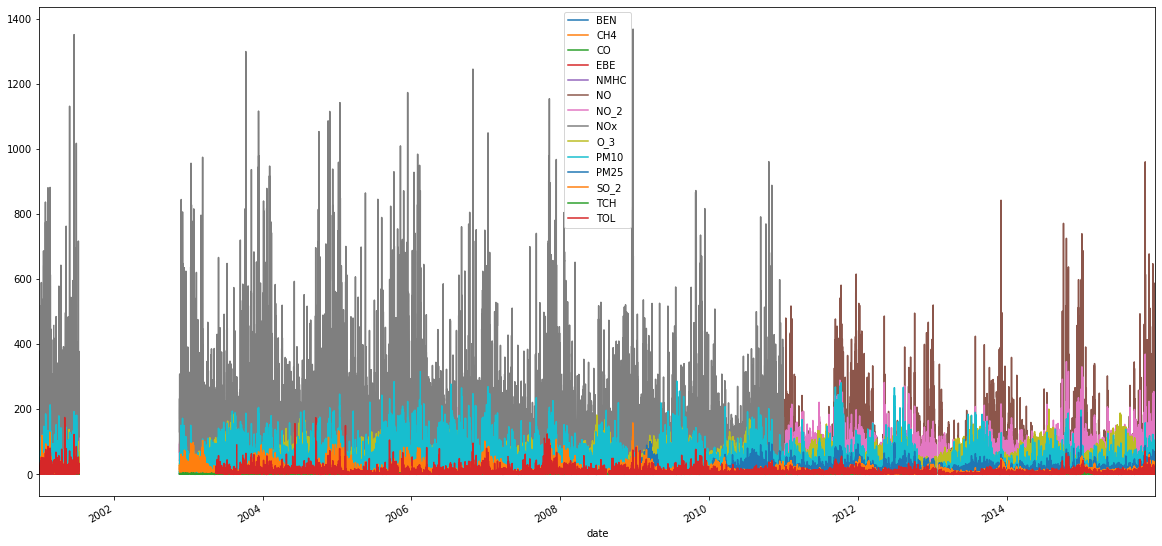

In [17]:
# for em_s in emissions_st:
emissions[28079008].plot(figsize=(20,10))
plt.show()

Gráfico de correlação

In [18]:
@interact(
    emission=widgets.,
    columns=widgets.SelectMultiple(options=weather.columns, disabled=False)
)
def cplot(emission, columns):
    try:
        corrplot(emissions[emission][list(columns)])
    except Exception as e:
        print(e)

SyntaxError: invalid syntax (<ipython-input-18-7041487751f0>, line 2)